In [1]:
# 준비작업
## 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import FactorAnalyzer
from factor_analyzer.rotator import Rotator
import warnings
warnings.filterwarnings('ignore')

In [2]:
## 데이터 로딩
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

newsgroups_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers', 'quotes')  # 노이즈 제거
)

In [3]:
# 데이터 탐색 및 전처리
## 데이터 정보 확인
print(f"데이터 형태:")
print(f"문서 수: {len(newsgroups_train.data)}")
print(f"카테고리: {newsgroups_train.target_names}")
print(f"각 카테고리별 문서 수:")
for i, category in enumerate(newsgroups_train.target_names):
    count = np.sum(newsgroups_train.target == i)
    print(f"  {category}: {count}개")

데이터 형태:
문서 수: 2034
카테고리: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
각 카테고리별 문서 수:
  alt.atheism: 480개
  comp.graphics: 584개
  sci.space: 593개
  talk.religion.misc: 377개


In [4]:
## 샘플 문서 확인
print(f"\n샘플 문서 (카테고리: {newsgroups_train.target_names[newsgroups_train.target[0]]}):")
print("="*60)
print(newsgroups_train.data[0][:500] + "...")
print("="*60)


샘플 문서 (카테고리: comp.graphics):
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule informati...


In [5]:
## TF-IDF 벡터화
# max_features를 제한하여 계산 효율성 향상
vectorizer = TfidfVectorizer(
    max_features=2000,  # 상위 2000개 단어 사용
    stop_words='english',  # 영어 불용어 제거
    min_df=5,  # 최소 5개 문서에서 나타나는 단어만 포함
    max_df=0.7,  # 70% 이상 문서에서 나타나는 단어 제외
    ngram_range=(1, 2)  # 1-gram과 2-gram 포함
)

X_tfidf = vectorizer.fit_transform(newsgroups_train.data)
X = X_tfidf.toarray()  # sparse matrix를 dense array로 변환
y = newsgroups_train.target
feature_names = vectorizer.get_feature_names_out()

print(f"TF-IDF 벡터화 결과:")
print(f"문서 수 (n): {X.shape[0]}")
print(f"특성 수 (p): {X.shape[1]} (단어/구문)")
print(f"n/p 비율: {X.shape[0]/X.shape[1]:.3f}")
print(f"데이터 희소성: {np.mean(X == 0):.3f} ({np.mean(X == 0)*100:.1f}% 영값)")

TF-IDF 벡터화 결과:
문서 수 (n): 2034
특성 수 (p): 2000 (단어/구문)
n/p 비율: 1.017
데이터 희소성: 0.981 (98.1% 영값)


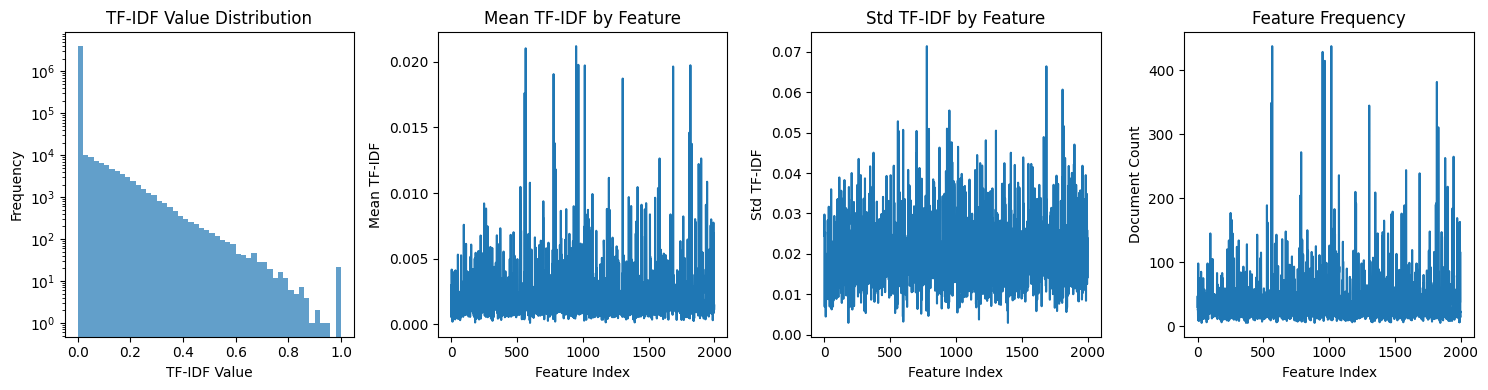

In [8]:
## TF-IDF 분포 시각화
plt.figure(figsize=(15, 4))

plt.subplot(141)
plt.hist(X.flatten(), bins=50, alpha=0.7)
plt.title('TF-IDF Value Distribution')
plt.xlabel('TF-IDF Value')
plt.ylabel('Frequency')
plt.yscale('log')

plt.subplot(142)
plt.plot(X.mean(axis=0))
plt.title('Mean TF-IDF by Feature')
plt.xlabel('Feature Index')
plt.ylabel('Mean TF-IDF')

plt.subplot(143)
plt.plot(X.std(axis=0))
plt.title('Std TF-IDF by Feature')
plt.xlabel('Feature Index')
plt.ylabel('Std TF-IDF')

plt.subplot(144)
non_zero_counts = np.sum(X > 0, axis=0)
plt.plot(non_zero_counts)
plt.title('Feature Frequency')
plt.xlabel('Feature Index')
plt.ylabel('Document Count')

plt.tight_layout()
plt.show()

In [7]:
## TF-IDF 내 중요 단어 확인
feature_importance = X.mean(axis=0)
top_features_idx = np.argsort(feature_importance)[-20:][::-1]
print(f"\n상위 20개 중요 단어/구문:")
for i, idx in enumerate(top_features_idx):
    print(f"{i+1:2d}. {feature_names[idx]}: {feature_importance[idx]:.4f}")


상위 20개 중요 단어/구문:
 1. just: 0.0212
 2. don: 0.0210
 3. know: 0.0198
 4. think: 0.0197
 5. like: 0.0197
 6. space: 0.0196
 7. god: 0.0191
 8. people: 0.0187
 9. does: 0.0176
10. thanks: 0.0146
11. good: 0.0138
12. time: 0.0138
13. ve: 0.0126
14. say: 0.0126
15. use: 0.0122
16. graphics: 0.0118
17. need: 0.0112
18. way: 0.0109
19. edu: 0.0108
20. did: 0.0105


In [14]:
## 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"표준화 후 데이터 범위: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")
print(f"표준화 후 평균: {X_scaled.mean():.6f}")
print(f"표준화 후 표준편차: {X_scaled.std():.6f}")

표준화 후 데이터 범위: [-0.42, 43.67]
표준화 후 평균: -0.000000
표준화 후 표준편차: 1.000000


In [11]:
# 데이터 분석
## PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA 변환 후 데이터 형태: {X_pca.shape}")
print(f"원본 특성 수: {X.shape[1]}")
print(f"주성분 수: {X_pca.shape[1]}")


PCA 변환 후 데이터 형태: (2034, 2000)
원본 특성 수: 2000
주성분 수: 2000


In [12]:
## 설명된 분산 비율
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print(f"\nPCA 결과 요약:")
print(f"첫 번째 주성분 설명 분산: {explained_variance_ratio[0]:.4f} ({explained_variance_ratio[0]*100:.2f}%)")
print(f"두 번째 주성분 설명 분산: {explained_variance_ratio[1]:.4f} ({explained_variance_ratio[1]*100:.2f}%)")
print(f"세 번째 주성분 설명 분산: {explained_variance_ratio[2]:.4f} ({explained_variance_ratio[2]*100:.2f}%)")


PCA 결과 요약:
첫 번째 주성분 설명 분산: 0.0068 (0.68%)
두 번째 주성분 설명 분산: 0.0057 (0.57%)
세 번째 주성분 설명 분산: 0.0041 (0.41%)


In [13]:
## 90%, 95% 분산을 설명하는 데 필요한 주성분 수 확인
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print(f"\n분산 설명을 위한 필요 주성분 수:")
print(f"90% 분산 설명: {n_components_90}개 성분")
print(f"95% 분산 설명: {n_components_95}개 성분")


분산 설명을 위한 필요 주성분 수:
90% 분산 설명: 978개 성분
95% 분산 설명: 1174개 성분


In [26]:
## 분산 설명 비율 상세 확인
print("주성분별 설명된 분산 비율:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1:2d}: {ratio:.4f} ({cumulative_variance_ratio[i]:.4f} cumulative)")
    
    # 누적 분산이 0.9를 넘으면 출력 중지
    if cumulative_variance_ratio[i] >= 0.9:
        print(f"\n90% 분산 설명을 위해 필요한 주성분 개수 : {i+1}개 {cumulative_variance_ratio[i]:.4f})")
        break


주성분별 설명된 분산 비율:
PC 1: 0.0068 (0.0068 cumulative)
PC 2: 0.0057 (0.0124 cumulative)
PC 3: 0.0041 (0.0166 cumulative)
PC 4: 0.0035 (0.0201 cumulative)
PC 5: 0.0035 (0.0235 cumulative)
PC 6: 0.0033 (0.0268 cumulative)
PC 7: 0.0031 (0.0299 cumulative)
PC 8: 0.0029 (0.0329 cumulative)
PC 9: 0.0029 (0.0358 cumulative)
PC10: 0.0029 (0.0386 cumulative)
PC11: 0.0028 (0.0414 cumulative)
PC12: 0.0026 (0.0440 cumulative)
PC13: 0.0026 (0.0466 cumulative)
PC14: 0.0025 (0.0491 cumulative)
PC15: 0.0024 (0.0515 cumulative)
PC16: 0.0024 (0.0539 cumulative)
PC17: 0.0024 (0.0563 cumulative)
PC18: 0.0024 (0.0587 cumulative)
PC19: 0.0023 (0.0610 cumulative)
PC20: 0.0023 (0.0633 cumulative)
PC21: 0.0023 (0.0656 cumulative)
PC22: 0.0022 (0.0678 cumulative)
PC23: 0.0022 (0.0700 cumulative)
PC24: 0.0022 (0.0722 cumulative)
PC25: 0.0022 (0.0744 cumulative)
PC26: 0.0022 (0.0766 cumulative)
PC27: 0.0021 (0.0787 cumulative)
PC28: 0.0021 (0.0808 cumulative)
PC29: 0.0021 (0.0829 cumulative)
PC30: 0.0021 (0.0850 cumula

In [17]:
## 주성분 로딩값(Component loadings) 확인
n_components_analyze = 5  # 처음 5개 주성분 분석

loadings = pd.DataFrame(
    pca.components_[:n_components_analyze].T,
    columns=[f'PC{i+1}' for i in range(n_components_analyze)],
    index=feature_names
)

print("주성분 로딩값 (처음 5개 성분):")
print(loadings.head(10))

## 각 주성분에서 가장 중요한 단어들 찾기
def get_top_words_for_component(component_idx, n_words=10):
    """특정 주성분에서 가장 영향력이 큰 단어들 추출"""
    loadings_abs = np.abs(pca.components_[component_idx])
    top_indices = np.argsort(loadings_abs)[-n_words:][::-1]
    
    top_words = []
    for idx in top_indices:
        word = feature_names[idx]
        loading = pca.components_[component_idx][idx]
        top_words.append((word, loading))
    
    return top_words

print(f"\n각 주성분별 주요 단어들:")
for i in range(min(5, len(pca.components_))):
    print(f"\nPC{i+1} (설명 분산: {explained_variance_ratio[i]:.3f}):")
    top_words = get_top_words_for_component(i, 8)
    for j, (word, loading) in enumerate(top_words):
        print(f"  {j+1}. {word:15s}: {loading:7.4f}")


주성분 로딩값 (처음 5개 성분):
           PC1       PC2       PC3       PC4       PC5
00    0.029677 -0.007086  0.007142 -0.001608 -0.017901
000   0.036899  0.015529 -0.012516  0.002628 -0.016727
01    0.021794 -0.005486 -0.001934  0.011894 -0.000187
04    0.076638  0.025703  0.013998  0.037048  0.004340
05    0.017841 -0.000683  0.000347  0.013523 -0.008958
10    0.061541  0.023580  0.002283  0.008846 -0.022123
100   0.027223  0.006198  0.001908  0.003670 -0.003293
1000  0.018437  0.005382  0.003173 -0.005230  0.016049
11    0.047083  0.014132  0.033774  0.024264  0.001057
12    0.043616  0.018622  0.009609  0.014805 -0.010950

각 주성분별 주요 단어들:

PC1 (설명 분산: 0.007):
  1. space          :  0.1186
  2. nasa           :  0.0957
  3. data           :  0.0942
  4. satellite      :  0.0885
  5. princeton      :  0.0876
  6. 14             :  0.0828
  7. mission        :  0.0812
  8. 93             :  0.0793

PC2 (설명 분산: 0.006):
  1. people         :  0.1089
  2. god            :  0.0853
  3. believe     

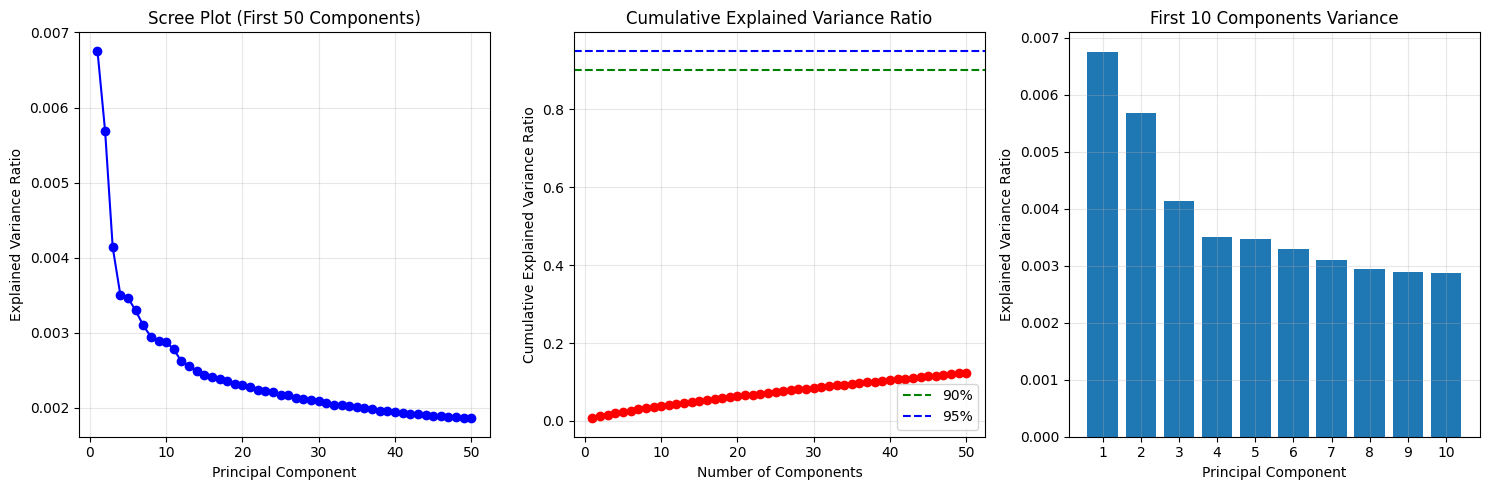

In [16]:
## 결과 시각화
plt.figure(figsize=(15, 5))

### 스크리 플롯
plt.subplot(131)
n_show = min(50, len(explained_variance_ratio)) # 처음 50개 성분만 표시
plt.plot(range(1, n_show + 1), explained_variance_ratio[:n_show], 'bo-')
plt.title('Scree Plot (First 50 Components)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, alpha=0.3)

### 누적 분산 비율
plt.subplot(132)
plt.plot(range(1, n_show + 1), cumulative_variance_ratio[:n_show], 'ro-')
plt.axhline(y=0.9, color='g', linestyle='--', label='90%')
plt.axhline(y=0.95, color='b', linestyle='--', label='95%')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.legend()
plt.grid(True, alpha=0.3)

### 처음 10개 성분의 상세 분산 비율
plt.subplot(133)
plt.bar(range(1, 11), explained_variance_ratio[:10])
plt.title('First 10 Components Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 11))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

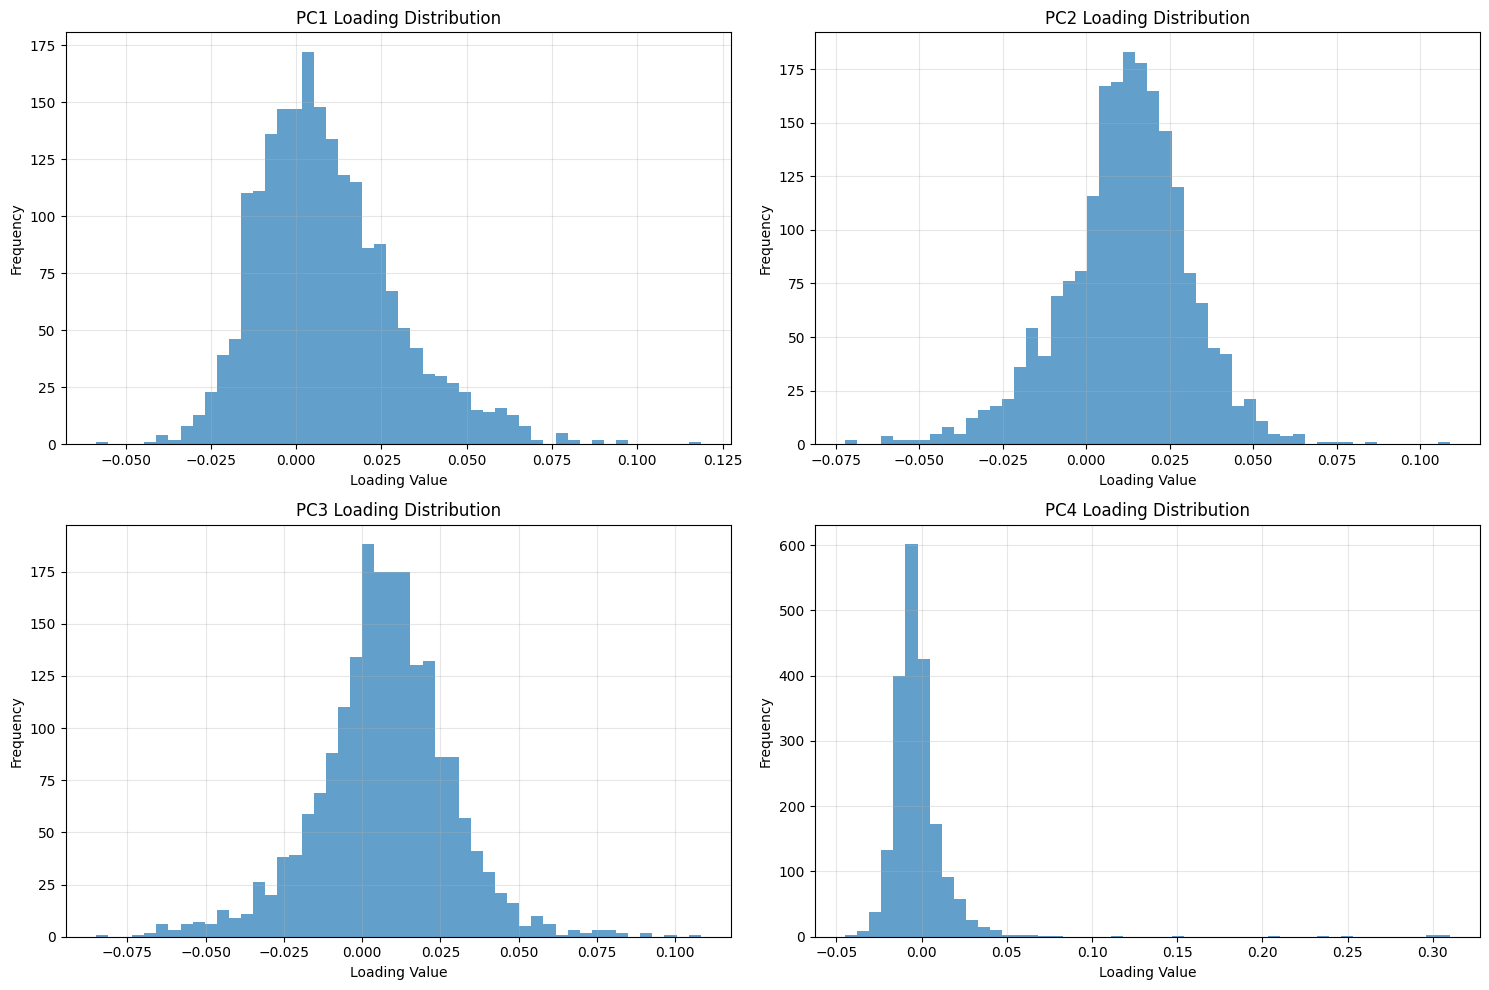

In [19]:
### 로딩값 분포 시각화
plt.figure(figsize=(15, 10))

for i in range(min(4, n_components_analyze)):
    plt.subplot(2, 2, i+1)
    plt.hist(pca.components_[i], bins=50, alpha=0.7)
    plt.title(f'PC{i+1} Loading Distribution')
    plt.xlabel('Loading Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

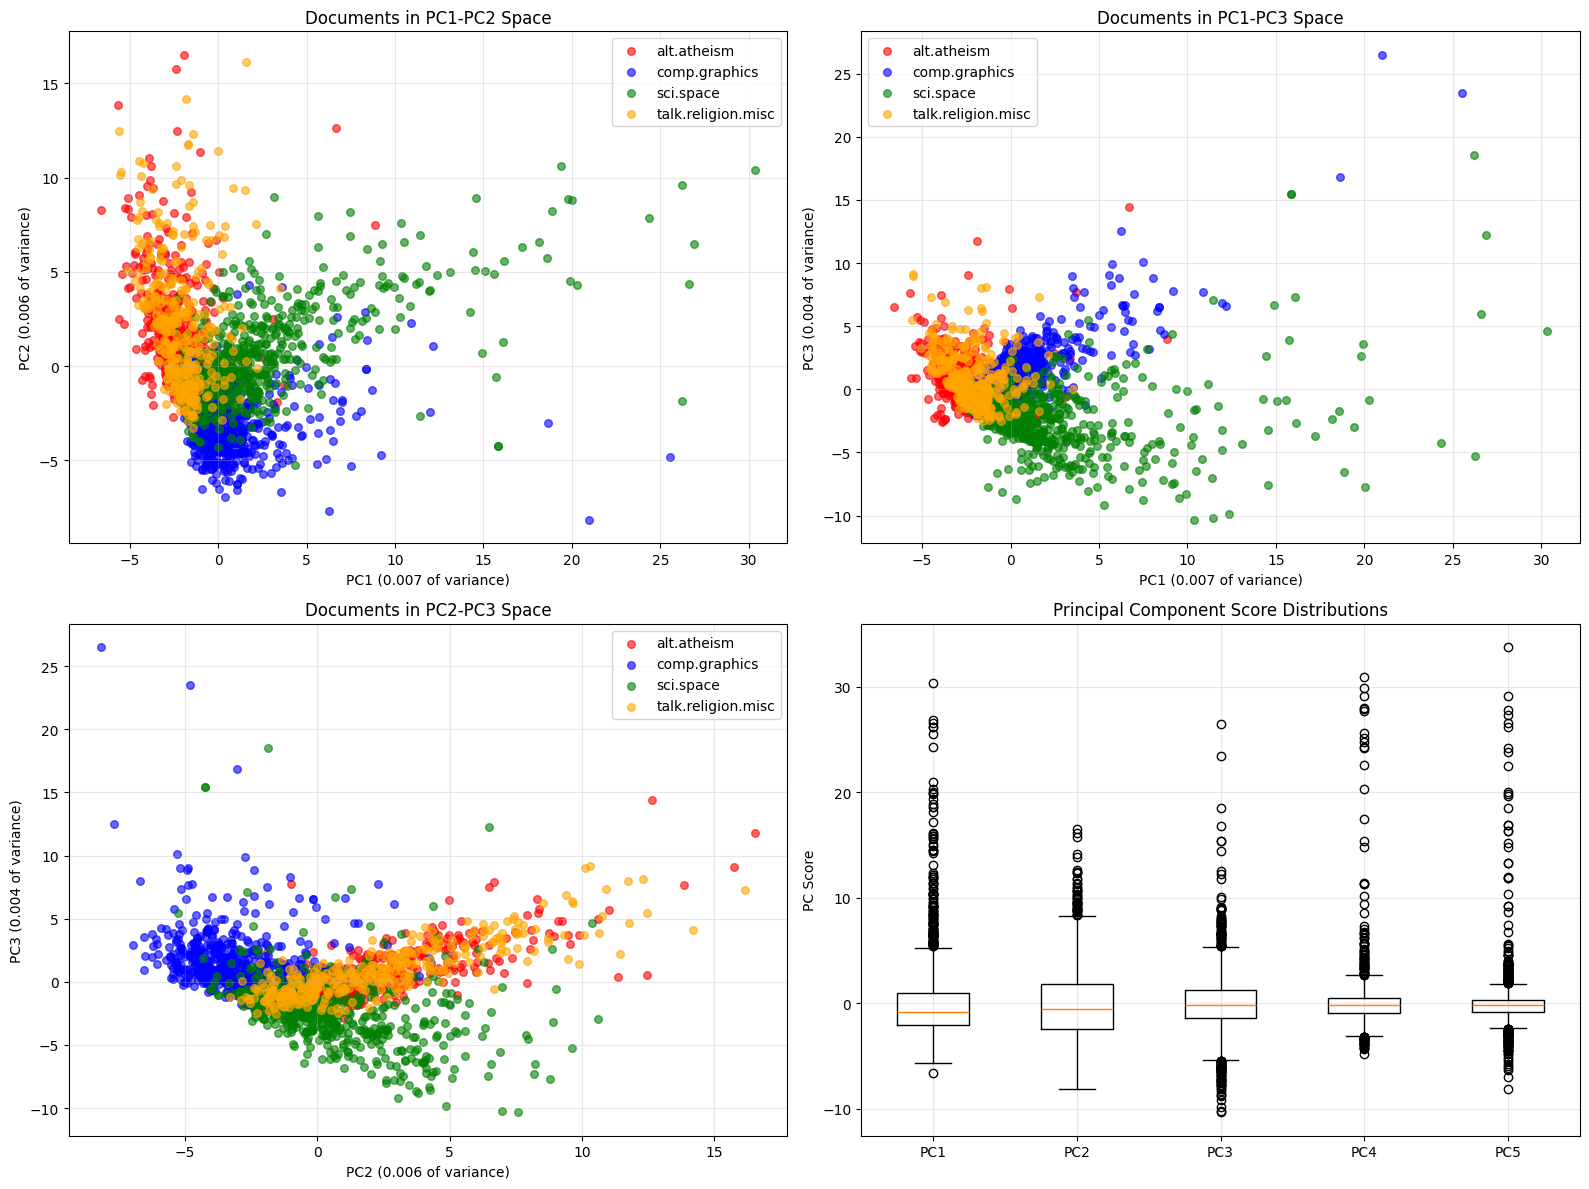

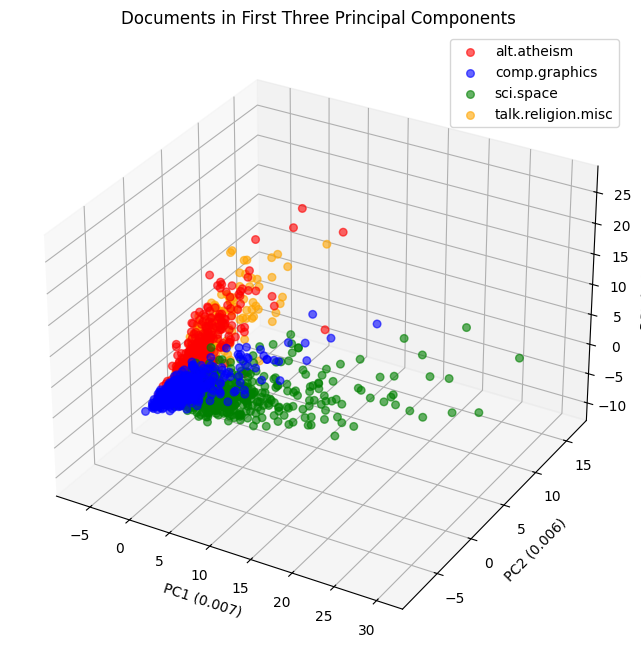

In [27]:
## 주성분 산점도
category_names = newsgroups_train.target_names

plt.figure(figsize=(16, 12))

### 2D 산점도 (PC1 vs PC2)
plt.subplot(2, 2, 1)
colors = ['red', 'blue', 'green', 'orange']
for i, category in enumerate(category_names):
    mask = y == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                c=colors[i], label=category, alpha=0.6, s=30)

plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.3f} of variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.3f} of variance)')
plt.title('Documents in PC1-PC2 Space')
plt.legend()
plt.grid(True, alpha=0.3)

### 2D 산점도 (PC1 vs PC3)
plt.subplot(2, 2, 2)
for i, category in enumerate(category_names):
    mask = y == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 2], 
                c=colors[i], label=category, alpha=0.6, s=30)

plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.3f} of variance)')
plt.ylabel(f'PC3 ({explained_variance_ratio[2]:.3f} of variance)')
plt.title('Documents in PC1-PC3 Space')
plt.legend()
plt.grid(True, alpha=0.3)

### 2D 산점도 (PC2 vs PC3)
plt.subplot(2, 2, 3)
for i, category in enumerate(category_names):
    mask = y == i
    plt.scatter(X_pca[mask, 1], X_pca[mask, 2], 
                c=colors[i], label=category, alpha=0.6, s=30)

plt.xlabel(f'PC2 ({explained_variance_ratio[1]:.3f} of variance)')
plt.ylabel(f'PC3 ({explained_variance_ratio[2]:.3f} of variance)')
plt.title('Documents in PC2-PC3 Space')
plt.legend()
plt.grid(True, alpha=0.3)

### 주성분 점수 분포
plt.subplot(2, 2, 4)
plt.boxplot([X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], X_pca[:, 3], X_pca[:, 4]],
            labels=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
plt.title('Principal Component Score Distributions')
plt.ylabel('PC Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3D 시각화
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i, category in enumerate(category_names):
    mask = y == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2], 
               c=colors[i], label=category, alpha=0.6, s=30)

ax.set_xlabel(f'PC1 ({explained_variance_ratio[0]:.3f})')
ax.set_ylabel(f'PC2 ({explained_variance_ratio[1]:.3f})')
ax.set_zlabel(f'PC3 ({explained_variance_ratio[2]:.3f})')
ax.set_title('Documents in First Three Principal Components')
ax.legend()
plt.show()

In [30]:
## Rotation
n_factors = 5  # 회전할 인수 수

### Varimax
rotator_varimax = Rotator(method='varimax')
loadings_varimax = rotator_varimax.fit_transform(pca.components_[:n_factors].T)

### Promax
rotator_promax = Rotator(method='promax')
loadings_promax = rotator_promax.fit_transform(pca.components_[:n_factors].T)

### Oblimin
rotator_oblimin = Rotator(method='oblimin')
loadings_oblimin = rotator_oblimin.fit_transform(pca.components_[:n_factors].T)

### 결과를 데이터프레임으로 변환
df_varimax = pd.DataFrame(
    loadings_varimax,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=feature_names
)

df_promax = pd.DataFrame(
    loadings_promax,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=feature_names
)

df_oblimin = pd.DataFrame(
    loadings_oblimin,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=feature_names
)

# 각 rotation 방법별 주요 단어 확인
def get_top_words_rotation(loadings_df, factor_idx, n_words=8):
    """회전된 인수에서 가장 중요한 단어들 추출"""
    factor_name = f'Factor{factor_idx+1}'
    loadings_abs = np.abs(loadings_df[factor_name])
    top_indices = loadings_abs.nlargest(n_words).index
    
    top_words = []
    for word in top_indices:
        loading = loadings_df.loc[word, factor_name]
        top_words.append((word, loading))
    
    return top_words

print(f"\n=== Varimax Rotation 결과 ===")
for i in range(n_factors):
    print(f"\nFactor{i+1}:")
    top_words = get_top_words_rotation(df_varimax, i)
    for j, (word, loading) in enumerate(top_words):
        print(f"  {j+1}. {word:15s}: {loading:7.4f}")


=== Varimax Rotation 결과 ===

Factor1:
  1. space          :  0.1209
  2. launch         :  0.1020
  3. satellite      :  0.0910
  4. lunar          :  0.0886
  5. mission        :  0.0869
  6. vehicle        :  0.0853
  7. director       :  0.0844
  8. rocket         :  0.0841

Factor2:
  1. god            :  0.1122
  2. people         :  0.1076
  3. bible          :  0.1006
  4. jesus          :  0.0985
  5. believe        :  0.0892
  6. christian      :  0.0857
  7. faith          :  0.0800
  8. belief         :  0.0790

Factor3:
  1. pub            :  0.1095
  2. graphics       :  0.1087
  3. image          :  0.1061
  4. blew           : -0.0973
  5. edu 128        :  0.0968
  6. tek com        : -0.0954
  7. tek            : -0.0951
  8. vice           : -0.0947

Factor4:
  1. blew           :  0.2816
  2. tek            :  0.2795
  3. tek com        :  0.2795
  4. sea            :  0.2750
  5. vice           :  0.2735
  6. stay           :  0.2269
  7. bob            :  0.2144
 

In [31]:
print(f"\n=== Promax Rotation 결과 ===")
for i in range(n_factors):
    print(f"\nFactor{i+1}:")
    top_words = get_top_words_rotation(df_promax, i)
    for j, (word, loading) in enumerate(top_words):
        print(f"  {j+1}. {word:15s}: {loading:7.4f}")


=== Promax Rotation 결과 ===

Factor1:
  1. space          :  0.1205
  2. launch         :  0.1039
  3. satellite      :  0.0935
  4. lunar          :  0.0898
  5. mission        :  0.0882
  6. vehicle        :  0.0872
  7. director       :  0.0867
  8. rocket         :  0.0859

Factor2:
  1. god            :  0.1145
  2. people         :  0.1040
  3. bible          :  0.1023
  4. jesus          :  0.1001
  5. believe        :  0.0897
  6. christian      :  0.0865
  7. faith          :  0.0813
  8. belief         :  0.0802

Factor3:
  1. blew           : -0.1337
  2. tek com        : -0.1315
  3. tek            : -0.1311
  4. vice           : -0.1301
  5. sea            : -0.1293
  6. stay           : -0.1119
  7. graphics       :  0.1108
  8. pub            :  0.1102

Factor4:
  1. blew           :  0.3019
  2. tek            :  0.2994
  3. tek com        :  0.2994
  4. sea            :  0.2945
  5. vice           :  0.2934
  6. stay           :  0.2431
  7. bob            :  0.2296
  

In [32]:
print(f"\n=== Oblimin Rotation 결과 ===")
for i in range(n_factors):
    print(f"\nFactor{i+1}:")
    top_words = get_top_words_rotation(df_oblimin, i)
    for j, (word, loading) in enumerate(top_words):
        print(f"  {j+1}. {word:15s}: {loading:7.4f}")


=== Oblimin Rotation 결과 ===

Factor1:
  1. space          :  0.1326
  2. launch         :  0.1012
  3. satellite      :  0.0952
  4. mission        :  0.0945
  5. lunar          :  0.0892
  6. earth          :  0.0871
  7. delta          :  0.0845
  8. orbit          :  0.0844

Factor2:
  1. god            :  0.1166
  2. people         :  0.1128
  3. bible          :  0.0994
  4. jesus          :  0.0987
  5. believe        :  0.0962
  6. christian      :  0.0850
  7. existence      :  0.0816
  8. belief         :  0.0813

Factor3:
  1. pub            :  0.1481
  2. available anonymous:  0.1353
  3. 129            :  0.1332
  4. archive        :  0.1187
  5. edu 128        :  0.1137
  6. anonymous ftp  :  0.1124
  7. anonymous      :  0.1118
  8. ftp            :  0.1102

Factor4:
  1. blew           :  0.3125
  2. tek com        :  0.3098
  3. tek            :  0.3097
  4. sea            :  0.3036
  5. vice           :  0.3033
  6. stay           :  0.2530
  7. bob            :  0.23

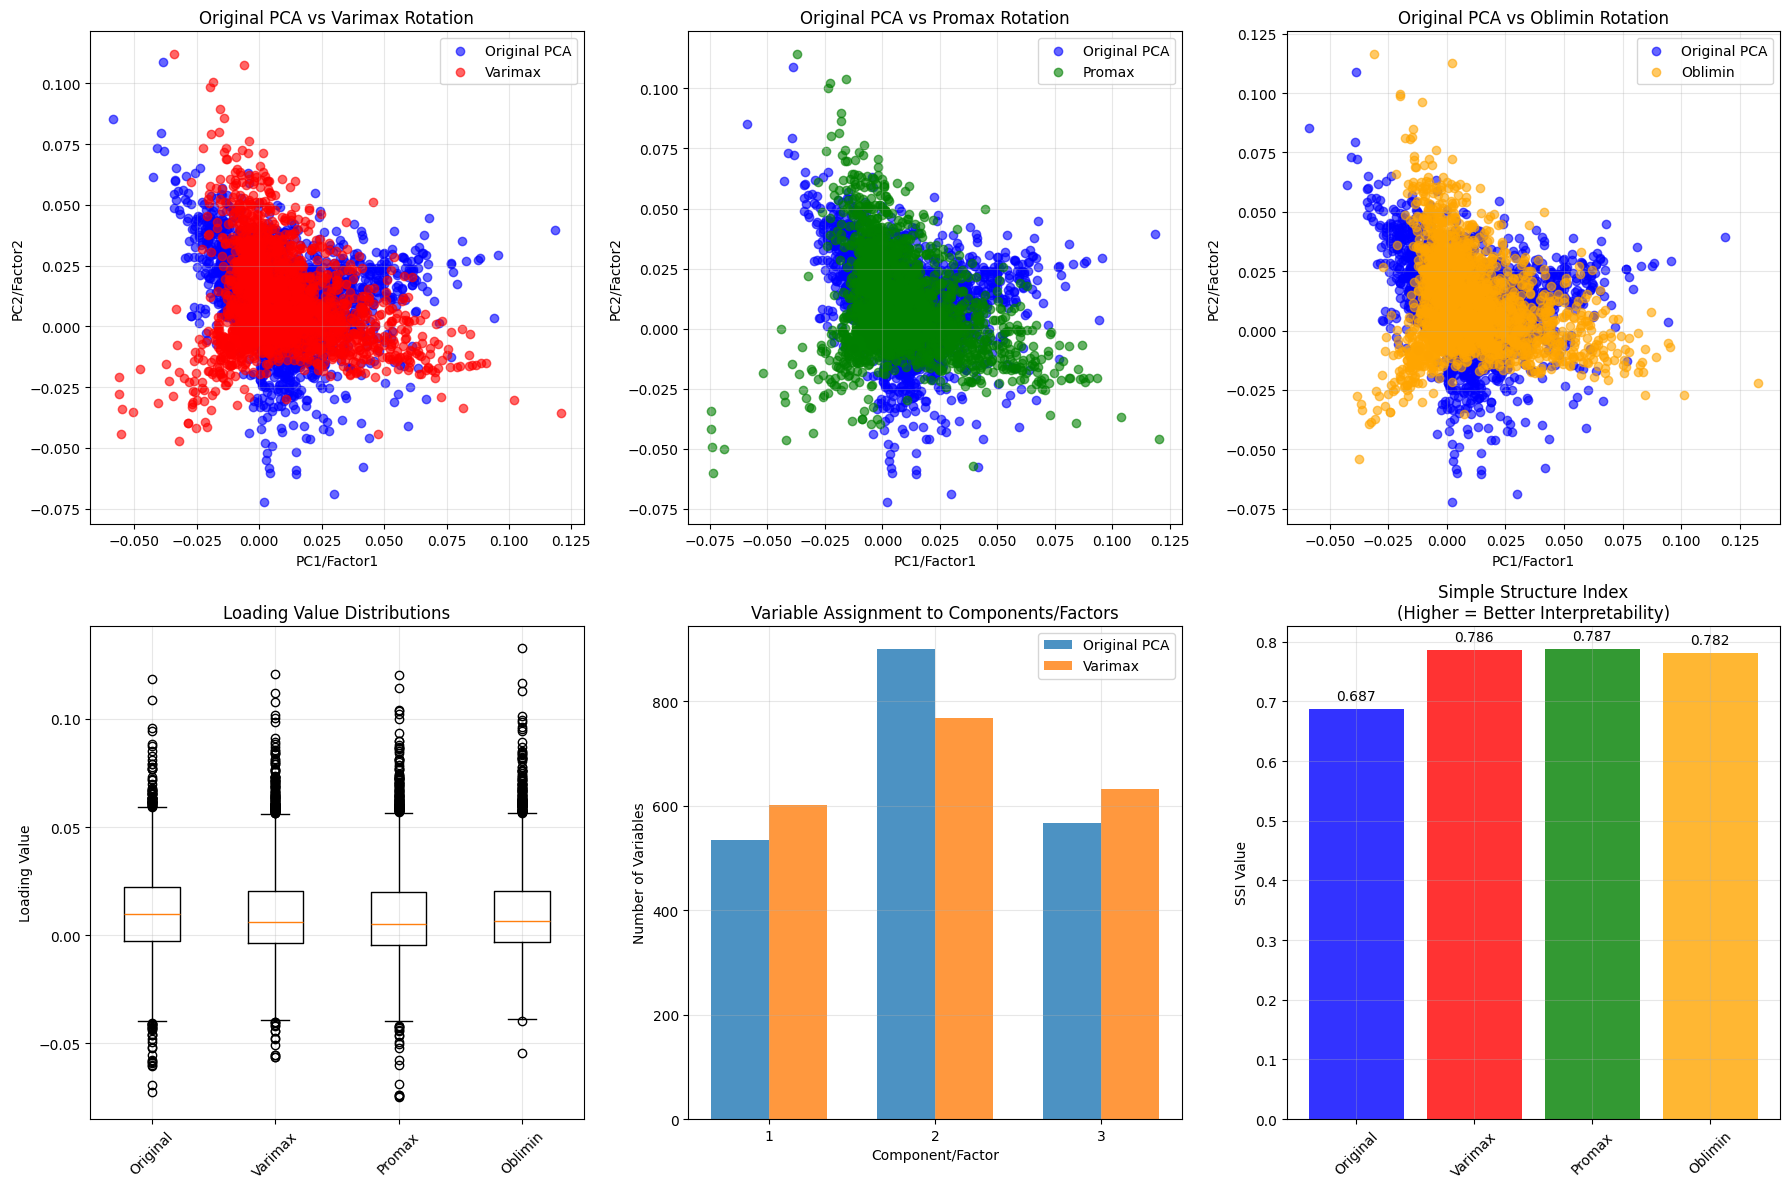

In [ ]:
## Rotation 결과 시각화
plt.figure(figsize=(18, 12))

### 원본 PCA vs Varimax
plt.subplot(2, 3, 1)
plt.scatter(loadings['PC1'], loadings['PC2'], alpha=0.6, color='blue', label='Original PCA')
plt.scatter(df_varimax['Factor1'], df_varimax['Factor2'], alpha=0.6, color='red', label='Varimax')
plt.xlabel('PC1/Factor1')
plt.ylabel('PC2/Factor2')
plt.title('Original PCA vs Varimax Rotation')
plt.legend()
plt.grid(True, alpha=0.3)

### 원본 PCA vs Promax
plt.subplot(2, 3, 2)
plt.scatter(loadings['PC1'], loadings['PC2'], alpha=0.6, color='blue', label='Original PCA')
plt.scatter(df_promax['Factor1'], df_promax['Factor2'], alpha=0.6, color='green', label='Promax')
plt.xlabel('PC1/Factor1')
plt.ylabel('PC2/Factor2')
plt.title('Original PCA vs Promax Rotation')
plt.legend()
plt.grid(True, alpha=0.3)

### 원본 PCA vs Oblimin
plt.subplot(2, 3, 3)
plt.scatter(loadings['PC1'], loadings['PC2'], alpha=0.6, color='blue', label='Original PCA')
plt.scatter(df_oblimin['Factor1'], df_oblimin['Factor2'], alpha=0.6, color='orange', label='Oblimin')
plt.xlabel('PC1/Factor1')
plt.ylabel('PC2/Factor2')
plt.title('Original PCA vs Oblimin Rotation')
plt.legend()
plt.grid(True, alpha=0.3)

### 로딩값 분포 비교
methods = ['Original', 'Varimax', 'Promax', 'Oblimin']
loading_data = [
    loadings[['PC1', 'PC2']].values.flatten(),
    df_varimax[['Factor1', 'Factor2']].values.flatten(),
    df_promax[['Factor1', 'Factor2']].values.flatten(),
    df_oblimin[['Factor1', 'Factor2']].values.flatten()
]

plt.subplot(2, 3, 4)
plt.boxplot(loading_data, labels=methods)
plt.title('Loading Value Distributions')
plt.ylabel('Loading Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

### 각 변수별로 가장 높은 로딩값을 가진 인수 확인
plt.subplot(2, 3, 5)
original_dominant = loadings[['PC1', 'PC2', 'PC3']].abs().idxmax(axis=1)
varimax_dominant = df_varimax[['Factor1', 'Factor2', 'Factor3']].abs().idxmax(axis=1)

#### 인수별 변수 개수 계산
original_counts = original_dominant.value_counts()
varimax_counts = varimax_dominant.value_counts()

x = np.arange(3)
width = 0.35

plt.bar(x - width/2, [original_counts.get(f'PC{i+1}', 0) for i in range(3)], 
        width, label='Original PCA', alpha=0.8)
plt.bar(x + width/2, [varimax_counts.get(f'Factor{i+1}', 0) for i in range(3)], 
        width, label='Varimax', alpha=0.8)

plt.xlabel('Component/Factor')
plt.ylabel('Number of Variables')
plt.title('Variable Assignment to Components/Factors')
plt.xticks(x, ['1', '2', '3'])
plt.legend()
plt.grid(True, alpha=0.3)

### 단순구조 지수 계산 (Simple Structure Index)
def calculate_simple_structure_index(loadings_matrix):
    """단순구조 지수 계산 - 높을수록 해석이 용이"""
    squared_loadings = loadings_matrix ** 2
    # 각 변수에 대해 가장 큰 로딩의 제곱과 나머지의 제곱 비율
    max_loadings = np.max(squared_loadings, axis=1)
    sum_loadings = np.sum(squared_loadings, axis=1)
    other_loadings = sum_loadings - max_loadings
    
    # 0으로 나누는 것 방지
    ratio = np.where(sum_loadings > 0, max_loadings / sum_loadings, 0)
    return np.mean(ratio)

plt.subplot(2, 3, 6)
original_ssi = calculate_simple_structure_index(loadings[['PC1', 'PC2', 'PC3']].values)
varimax_ssi = calculate_simple_structure_index(df_varimax[['Factor1', 'Factor2', 'Factor3']].values)
promax_ssi = calculate_simple_structure_index(df_promax[['Factor1', 'Factor2', 'Factor3']].values)
oblimin_ssi = calculate_simple_structure_index(df_oblimin[['Factor1', 'Factor2', 'Factor3']].values)

ssi_values = [original_ssi, varimax_ssi, promax_ssi, oblimin_ssi]
plt.bar(methods, ssi_values, alpha=0.8, color=['blue', 'red', 'green', 'orange'])
plt.title('Simple Structure Index\n(Higher = Better Interpretability)')
plt.ylabel('SSI Value')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

### 값 표시
for i, v in enumerate(ssi_values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [35]:
### SSI
print(f"\n=== 단순구조 지수 (Simple Structure Index) ===")
print(f"Original PCA: {original_ssi:.4f}")
print(f"Varimax:      {varimax_ssi:.4f}")
print(f"Promax:       {promax_ssi:.4f}")
print(f"Oblimin:      {oblimin_ssi:.4f}")


=== 단순구조 지수 (Simple Structure Index) ===
Original PCA: 0.6871
Varimax:      0.7859
Promax:       0.7872
Oblimin:      0.7816


In [37]:
# 분석 결과 리포트

print(f"\n1. 데이터 특성:")
print(f"   - 총 문서 수 (n): {X.shape[0]}")
print(f"   - 단어/구문 수 (p): {X.shape[1]}")
print(f"   - 카테고리 수: {len(category_names)}")
print(f"   - n/p 비율: {X.shape[0]/X.shape[1]:.3f}")
print(f"   - 데이터 희소성: {np.mean(X == 0)*100:.1f}%")

print(f"\n2. PCA 분석 결과:")
print(f"   - 90% 분산 설명: {n_components_90}개 성분 ({n_components_90/X.shape[1]*100:.1f}%)")
print(f"   - 95% 분산 설명: {n_components_95}개 성분 ({n_components_95/X.shape[1]*100:.1f}%)")
print(f"   - 첫 5개 성분으로 설명: {cumulative_variance_ratio[4]:.4f} ({cumulative_variance_ratio[4]*100:.1f}%)")
print(f"   - 첫 10개 성분으로 설명: {cumulative_variance_ratio[9]:.4f} ({cumulative_variance_ratio[9]*100:.1f}%)")

print(f"\n3. Rotation 분석 결과:")
print(f"   - Varimax SSI: {varimax_ssi:.4f}")
print(f"   - Promax SSI:  {promax_ssi:.4f}")
print(f"   - Oblimin SSI: {oblimin_ssi:.4f}")
print(f"   - 최적 방법: {'Varimax' if varimax_ssi == max(varimax_ssi, promax_ssi, oblimin_ssi) else 'Promax' if promax_ssi == max(varimax_ssi, promax_ssi, oblimin_ssi) else 'Oblimin'}")

print(f"\n4. 차원축소 효과:")
original_size = X.shape[1]
reduced_size_90 = n_components_90
reduced_size_95 = n_components_95
compression_90 = (1 - reduced_size_90/original_size) * 100
compression_95 = (1 - reduced_size_95/original_size) * 100

print(f"   - 90% 정보 유지시 압축률: {compression_90:.1f}%")
print(f"   - 95% 정보 유지시 압축률: {compression_95:.1f}%")

# 카테고리별 주성분 점수 분석
print(f"\n5. 카테고리별 주성분 특성:")
for i, category in enumerate(category_names):
    mask = y == i
    pc1_mean = X_pca[mask, 0].mean()
    pc2_mean = X_pca[mask, 1].mean()
    pc3_mean = X_pca[mask, 2].mean()
    print(f"   {category:20s}: PC1={pc1_mean:6.2f}, PC2={pc2_mean:6.2f}, PC3={pc3_mean:6.2f}")

# 메모리 효율성
original_memory = X.nbytes / (1024**2)  # MB
reduced_memory_95 = (X.shape[0] * n_components_95 * 8) / (1024**2)  # float64 가정

print(f"\n6. 메모리 효율성:")
print(f"   - 원본 데이터: {original_memory:.2f} MB")
print(f"   - 95% 압축 후: {reduced_memory_95:.2f} MB")
print(f"   - 메모리 절약: {(1-reduced_memory_95/original_memory)*100:.1f}%")


1. 데이터 특성:
   - 총 문서 수 (n): 2034
   - 단어/구문 수 (p): 2000
   - 카테고리 수: 4
   - n/p 비율: 1.017
   - 데이터 희소성: 98.1%

2. PCA 분석 결과:
   - 90% 분산 설명: 978개 성분 (48.9%)
   - 95% 분산 설명: 1174개 성분 (58.7%)
   - 첫 5개 성분으로 설명: 0.0235 (2.4%)
   - 첫 10개 성분으로 설명: 0.0386 (3.9%)

3. Rotation 분석 결과:
   - Varimax SSI: 0.7859
   - Promax SSI:  0.7872
   - Oblimin SSI: 0.7816
   - 최적 방법: Promax

4. 차원축소 효과:
   - 90% 정보 유지시 압축률: 51.1%
   - 95% 정보 유지시 압축률: 41.3%

5. 카테고리별 주성분 특성:
   alt.atheism         : PC1= -2.35, PC2=  1.63, PC3=  0.41
   comp.graphics       : PC1=  0.70, PC2= -3.09, PC3=  1.48
   sci.space           : PC1=  2.51, PC2=  0.50, PC3= -2.23
   talk.religion.misc  : PC1= -2.04, PC2=  1.93, PC3=  0.69

6. 메모리 효율성:
   - 원본 데이터: 31.04 MB
   - 95% 압축 후: 18.22 MB
   - 메모리 절약: 41.3%
